<a href="https://colab.research.google.com/github/heejookang-sguniv/NLP-/blob/main/120220107_%EA%B0%95%ED%9D%AC%EC%A3%BC_electra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ELECTRA:Efficiently Learning an Encoder that Classifies Token Replacements Accurately

##120220107 강희주




### introduction

대량의 코퍼스에 대해 모델을 사전학습하고, 풀고자 하는 태스크에 대해 fine-tuning 하는 방법은 NLP 과제를 수행하는 데에 있어 성공적이었다. BERT에서 시작해서 RoBERTa, AIBERT, 그리고 google T5까지, 사전학습을 각각의 방식으로 진행하였지만, Masked Language Modeling(MLM) 혹은 Corrupted Language Modeling을 사전학습 과제로 사용했다는 공통점이 있다. 

MLM은 인풋 문장의 일부 토큰을 [MASK] 토큰으로 치환하고, 이를 치환 전의 원본 토큰으로 복원하는 태스크를 통해 pre-training하는 방법이다. 이 사전학습을 수행하는 동안 모델은 자연스럽게 단어뿐만 아니라 인풋 문장의 문맥적인 의미를 포착하는 방법을 학습한다. 그 결과, 다운스트림 자연어 처리 태스크에 대해 모델을 transfer하면 다량의 코퍼스에서 학습한 노하우를 바탕으로 좋은 성능을 내는 것이다. 

하지만 이러한 사전학습 방법은 기존의 autoregressive language modeling 학습에 비해 양방향 정보를 고려한다는 점에서 효과적인 학습을 할 수 있지만 몇 가지 문제점들이 있다. 
1. 전체 토큰 중 15%에 대해서만 loss가 발생한다. ( = 하나의 example에 대해서 고작 15%만 학습함)
2. (때문에)학습하는 데 비용이 많이 든다.. 
3. 학습 때는 [MASK] 토큰을 모델이 참고하여 예측하지만 실제로는 [MASK] 토큰이 존재하지 않는다. 

ELECTRA는 이에 대한 대안으로 각 샘플을 더 효과적으로 활용하는 사전학습 태스크인 Replaced Token Detection(RTD)을 제안한다. RTD는 generator를 이용해 실제 입력의 일부 토큰을 그럴싸한 가짜 토큰으로 바꾸고, 각 토큰이 실제 입력에 있는 진짜(original) 토큰인지 generator가 생성해낸 가짜(replaced)토큰인지 discriminator가 맞히는 이진 분류 문제이다. ELECTRA는 RTD 태스크로 입력의 15%가 아닌 모든 토큰에 대해서 학습하기 때문에 상당히 효율적이면서도 효과적이다. 결과적으로 ELECTRA는 모델 크기, 데이터, 컴퓨팅 리소스가 동일한 조건에서 기존 BERT의 성능을 능가하였다. 




### Method 

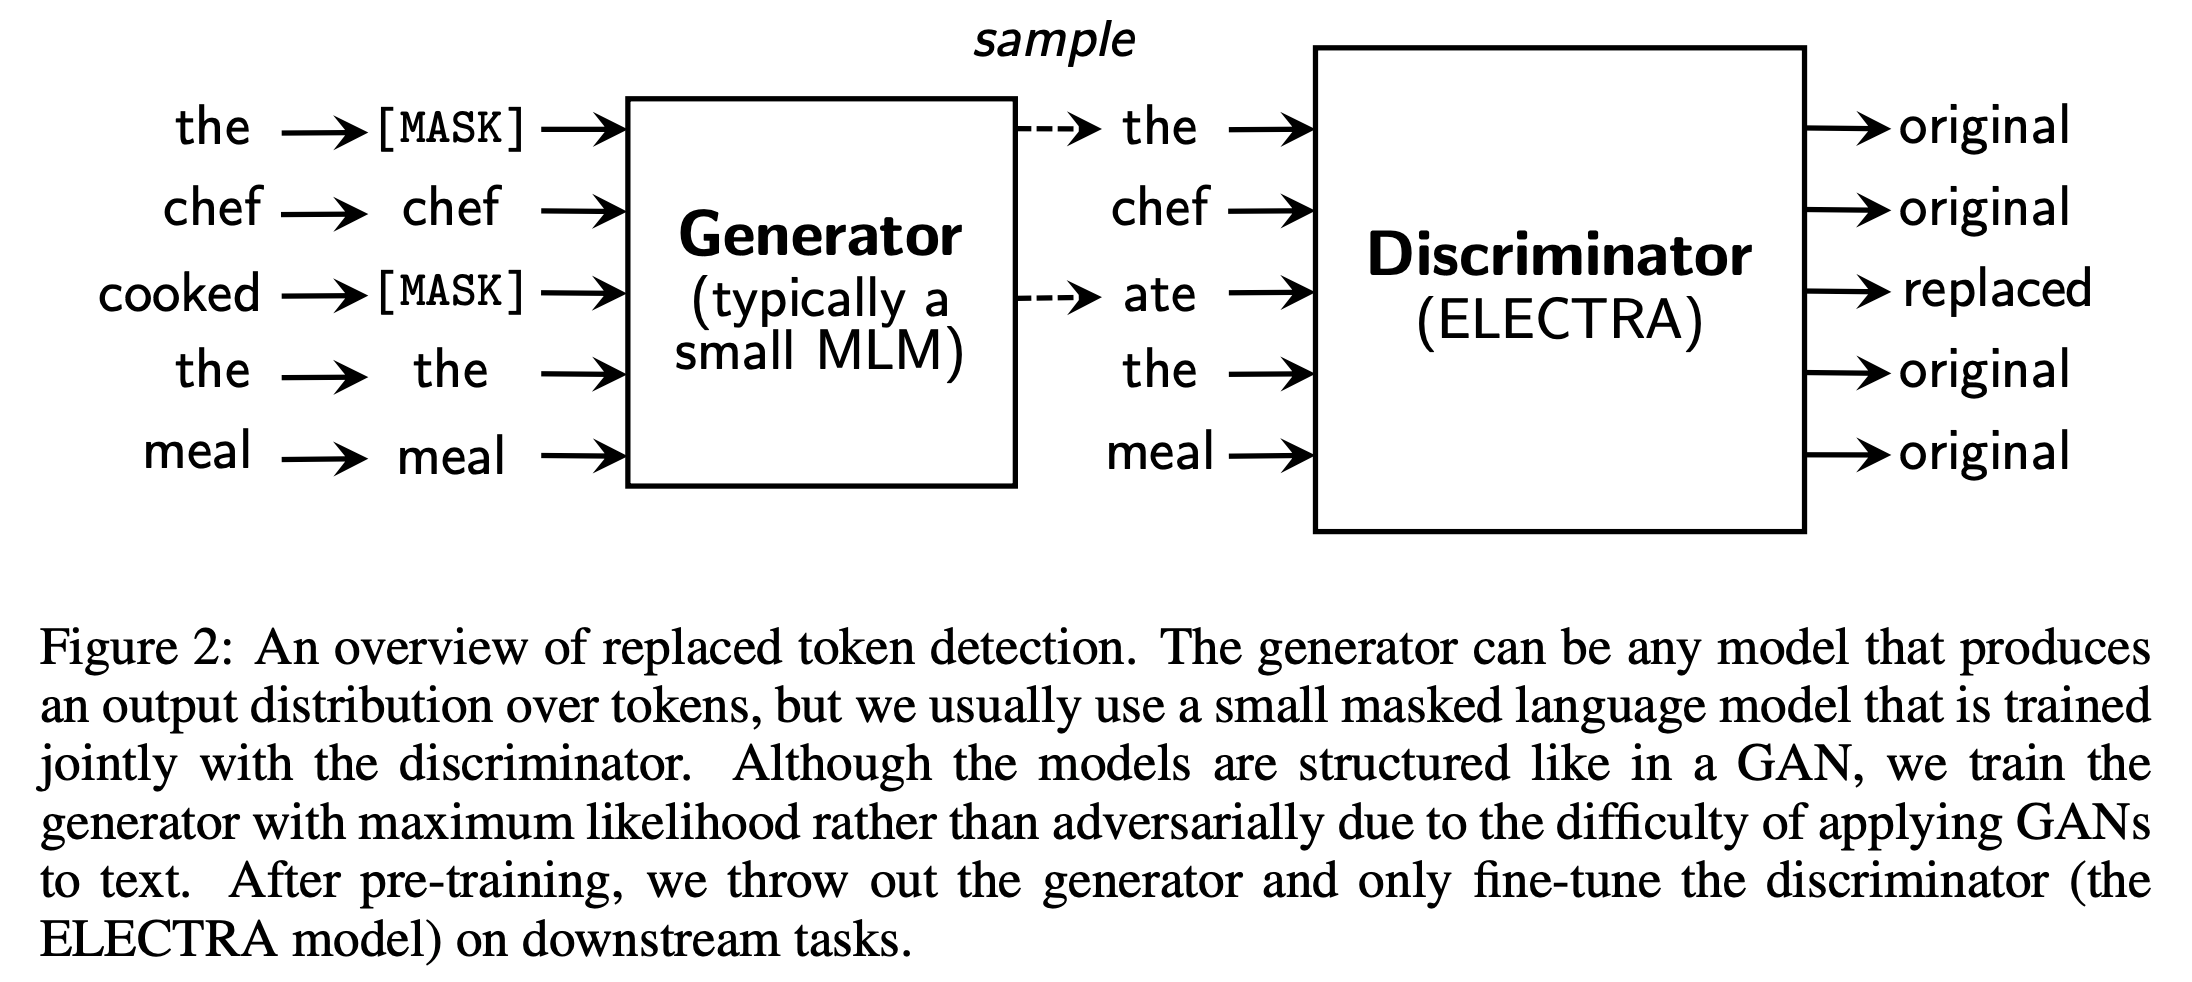



위의 그림에서 볼 수 있듯이 RTD 태스크를 통해 학습하기 위해서 generator G와 discriminator D, 두 개의 네트워크가 필요하다. 두 네트워크는 공통적으로 Transformer 인코더 구조이며, 토큰 시퀀스 **X** = [$x_1, x_2, ..., x_n$] 을 입력으로 받아서 문맥 정보를 반영한 벡터 시퀀스 h(**x**) = [$h_1, h_2, ... , h_n$]로 매핑시킨다. 

### Generator 

Generator G는 한마디로 BERT의 MLM과 똑같다. 구체적인 학습 매커니즘은 아래와 같다. 

1. 입력 **x** = [$x_1, x_2, ..., x_n$]에 대해서 마스킹할 위치의 집합 **m**=[$m_1, m_2, ..., m_k$]을 결정한다. 
   
    $\bullet$  모든 마스킹 위치는 1과 n 사이의 정수이며, 아래와 같이 수학적으로 표현할 수 있다. 
      
    $m_i \sim$ unif{1, n} for i = 1 to k
    
    $\bullet$ 마스킹할 개수 k는 보통 0.15n을 사용한다. (전체 토큰의 15%)

2. 결정한 위치에 있는 입력 토큰을 [MASK]로 치환한다. 
    
    $\bullet$ 이 과정을 $x^{masked} = REPLACE(x,m, [MASK] )$ 와 같이 표현한다. 

3. 마스킹된 입력 $x^{masked}$에 대해서 generator는 아래와 같이 원래 토큰이 무엇인지 예측한다. 이런 과정을 수학적으로 표현하면 아래와 같다. (t 번째 토큰에 대한 예측)

> $p_G(x_t | x^{masked}) = \frac{exp(e(x_t)^Th_G(x^{masked})_t)}{\sum_{x^{'}} exp(e(x^{'})^Th_G(x^{masked})_t)}$

   

*   e()는 임베딩을 의미한다. 위의 식은 language model의 출력 레이어와 임베딩 레이어의 가중치를 공유(weight sharing)하겠다는 의미이다. 


4. 최종적으로 아래와 같은 MLM loss로 학습한다. 



> $L_{MLM}(x, \theta_G) = E(\sum_{i \in m} -log_{p_G}(x_i | x^{masked}))$








      
       







###Discriminator 

Discriminator D는 입력 토큰 시퀀스에 대해서 각 토큰이 original 인지 replaced인지 이진 분류로 학습한다. 

1. Generator **G**를 이용해서 마스킹된 입력 토큰을 예측한다. (Generator의 학습 매커니즘 1~3 단계)

2. Generator G에서 마스킹할 위치의 집합 **m**에 해당하는 위치의 토큰을 [MASK]가 아닌 generator의 softmax 분포 $p_G(x_t|x)$에 대해 샘플링한 토큰으로 치환한다. 



*   *Original input*:[the, chef, cooked, the, meal]
*   *input for generator*: [[MASK], chef, [MASK], the, meal]
* input for disciminator : [the, chef, ate, the, meal]

* 첫 번째 단어는 샘플링 결과가 원래 입력 토큰과 동일하게 "the"가 나온 것이다. 
* 세 번째 단어는 샘플링 결과가 원래 입력 토믄인 "cooked"가 아니고 "ate"가 나온 것이다. 
*이 치환 과정은 수학적으로 다음과 같다.


> $x^{corrupt} = REPLACE(x, m, \hat{x})$



> $\hat{x} \sim p_G(x_i | x^{masked})$for $i \in$ **m**

3. 치환된 입력 x^{corrupt}에 대해서 discriminator는 아래와 같이 각 토큰이 원래 입력과 동일한지 치환된 것인지 예측한다. 



*   Target classes (2)
    * *original*: 이 위치에 해당하는 토큰은 원본 문장의 토큰과 같은 것
    * *replaced*: 이 위치에 해당하는 토큰은 generator G에 의해서 변형된 것 
    
*   이런 과정을 수학적으로 표현하면 아래와 같다. (t 번째 토큰에 대한 예측)


> $D(x^{corrupt}, t) = sigmoid(w^Th_D(x^{corrupt})_t)$

4. 최종적으로 아래와 같은 loss로 학습한다. 


> $L_{Disc}(x, \theta_D) = E(\sum_{t=1}^{n}-1(x_t^{corrupt}=x_t)logD(x^{corrupt}, t)-1(x_t^{corrupt} \neq x_t)log(1-D(x^{corrupt},t)))$















###GAN과의 차이점 

Generator와 Discriminator가 있다는 것이 GAN과의 공통점이지만, ELECTRA의 training objective는 GAN과 몇가지 차이점이 있다. 

1. Generator가 원래 토큰과 동일한 토큰을 생성했을 때, GAN은 negative sample(fake)로 간주하지만 ELECTRA는 positive sample로 간주하는 점.

2. Generator가 discriminator를 속이기 위해 adversarial 하게 학습하는 게 아니고 maximum likelihood로 학습한다는 점. 



*   generator에서 샘플링하는 과정 때문에 역전파가 불가능하고, 따라서 adversarial 하게 generator를 학습하는게 어려움. 
*   그래서 강화 학습으로 이를 구현해보았지만 maximum likelihood로 학습시키는 것보다 성능이 좋지 않았음(논문의 Appendix F 참조)

3. Generator의 입력으로 노이즈 벡터를 넣어주지 않는 점.


최종적으로 ELECTRA는 대용량 코퍼스에 대해서 generator loss와 discriminator loss의 합을 최소화하도록 학습한다. 앞에서 설명했듯이 샘플링 과정이 있기 때문에 discriminator loss는 generator로 역전파되지 않으며, 위의 구조로 pre-training을 마친 뒤에 generator는 버리고 discriminator만 취해서 downstream task으로 fine-tuning을 진행한다. 




### Model Extensions

ELECTRA의 성능을 더 향상시키는 몇 가지 기법과 실험 결과는 아래와 같다. 

### weight sharing  
Generator와 discriminator는 모두 transformer 인코더 구조이기 때문에 두 네트워크의 가중치를 공유하여 학습하는 weight sharing 기법을 써볼 수 있고, 이로써 pre-training의 효율 향상을 기대할 수 있다. 논문에서는 동일한 구조의 두 네트워크가 주어졌을 때, (1)임베딩의 가중치만 공유하고 그 외의 가중치는 따로 학습시키거나, (2)모든 가중치를 서로 공유하는 방법을 각각 실험하였다. 

결과적으로 모든 가중치를 공유하는 것이 가장 좋은 성능을 보였으며, 임베딩만 공유하는 방법도 거의 비슷하게 좋은 성능을 기록하였다. 이런 결과를 논문은 다음과 같이 해석한다. 



> Discriminator는 입력으로 들어온 토큰만 학습하는 반면, generator는 출력 레이어에서 softmax를 통해 사전에 있는 모든 토큰에 대해서 밀도있게 학습할 수 있다. ELECTRA는 결국 discriminator만을 취해서 사용하는데, 이때 generator와 임베딩을 공유해서 학습한 경우의 discrimanator는 훨씬 효과적으로 학습했을 것이고 결과적으로 결과적으로 좋은 성능을 기록한 것으로 보인다. 

성능 자체는 모든 가중치를 공유하는 방법이 약간 더 좋긴 했지만, generator와 discriminator의 크기를 반드시 동일하게 맞춰야 한다는 제약이 따른다. 결국 discriminator만 사용하는데 generator를 이와 동일한 크기로 가져가는 것은 학습의 효율을 떨어뜨릴 수 있으며, 아래에서 더 살펴보겠지만 더 작은 generator를 사용하는 것이 상당히 효과적이기 때문에 논문에서 소개하는 이후 실험은 모두 임베딩만 공유하는 세팅으로 진행하였다고 한다. 


### smaller generators 

Generator와 discriminator의 크기를 동일하게 가져간다면, ELECTRA를 학습하기 위해서는 BERT와 같은 일반 MLM 모델에 비해 단순 계산으로 거의 두 배의 계산량이 필요하다. 이 문제를 완화하기 위해서 generator의 크기를 줄여보는 실험을 진행한다(다른 하이퍼 파라미터는 그대로 두고 레이어의 크기만을 줄이는 것. 여기서 레이어의 크기란 히든 레이어의 크기, FFN의 크기, 어텐션 헤드의 수를 의미함).

모두 동일한 스텝만큼을 학습했기 때문에 작은 모델은 똑같은 계산량, 시간만큼 학습하면 더 많은 스텝을 돌 것이고, 결과적으로 작은 모델 입장에서는 계산량 대비 성능을 손해본 셈이다. 그럼에도 불구하고 discriminator의 크기 대비 1/4 - 1/2 크기의 generator를 사용했을 때 가장 좋은 성능을 보인다. 이런 실험 결과를 논문은 다음과 같이 해석한다. 



> Generator가 너무 강력하면 discriminator의 태스크가 너무 어려워져서 이런 현상이 나타날 수 있다. 게다가 discriminator의 파라미터를 실제 데이터 분포가 아닌 generator를 모델링하는 데 사용할 수도 있다. 







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! python3.7 -m pip install tensorflow-gpu==1.15.0
!pip install transformers==2.8.0
!git clone https://github.com/google-research/electra.git

/bin/bash: python3.7: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 563 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 31.5 MB/s 
     |████████████████████████████████| 132 kB 53.3 MB/s 
     |████████████████████████████████| 880 kB 46.0 MB/s 
     |████████████████████████████████| 7.4 MB 44.8 MB/s 
     |████████████████████████████████| 10.2 MB 39.4 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 140 kB 52.1 MB/s 
     |████████████████████████████████| 127 kB 65.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a8132fb9bbe709574377b6a47de03a2cc9016eea64b58c2d26698384b06e23fc
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found ex

In [ ]:
  !wget https://www.python.org/ftp/python/3.7.0/Python-3.7.0.tgz
  !tar xvfz Python-3.7.0.tgz
  !Python-3.7.0/configure
  !make
  !sudo make install

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_codecontext.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_colorizer.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_config.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_config_key.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_configdialog.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_debugger.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_delegator.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_editmenu.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_editor.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_grep.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_help.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_help_about.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_hist

In [ ]:
import tensorflow as tf

tf.__version__

'2.9.2'

In [ ]:
import os
import json
from transformers import AutoTokenizer

###Data 


OpenSubtitles에서 검색한 스페인어 영화 자막 데이터 세트에서 ELECTRA를 사전 학습합니다. 이 데이터 세트의 크기는 5.4GB이며 프리젠테이션을 위해 ~30MB의 작은 하위 집합에서 훈련할 것입니다.


In [ ]:
DATA_DIR = "./data" #@param {type: "string"}
TRAIN_SIZE = 1000000 #@param {type:"integer"}
MODEL_NAME = "electra-spanish" #@param {type: "string"}

In [ ]:
#스페인 영화 자막 데이터 세트 다운로드 및 압축 해제

if not os.path.exists(DATA_DIR):
  !mkdir -p $DATA_DIR
  !wget "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2016/mono/es.txt.gz" -O $DATA_DIR/OpenSubtitles.txt.gz
  !gzip -d $DATA_DIR/OpenSubtitles.txt.gz
  !head -n $TRAIN_SIZE $DATA_DIR/OpenSubtitles.txt > $DATA_DIR/train_data.txt 
  !rm $DATA_DIR/OpenSubtitles.txt

pre-training dataset를 구축하기 전에, corpus가 다음 형식인지 확인해야 한다. 


*   각각의 line은 문장이어야 한다. 
*   빈 줄은 두 문서를 구분한다. 



###build Pretraining Dataset

스페인어 텍스트를 처리하기 위해 [bert-base-multilingual-cased] 토크나이저를 사용하였다.  

In [ ]:
#pretrained 된 WordPiece 토크나이저를 저장하여 'vocab.txt'를 얻는다. 
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer.save_pretrained(DATA_DIR)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

('./data/vocab.txt',
 './data/special_tokens_map.json',
 './data/added_tokens.json')

build_pretraining_dataset.py를 사용하여 dump of raw text에서 사전 훈련 데이터 세트를 생성한다. 

In [ ]:
!python3 electra/build_pretraining_dataset.py \
  --corpus-dir $DATA_DIR \
  --vocab-file $DATA_DIR/vocab.txt \
  --output-dir $DATA_DIR/pretrain_tfrecords \
  --max-seq-length 128 \
  --blanks-separate-docs False \
  --no-lower-case \
  --num-processes 5

Job 0: Creating example writer
Job 1: Creating example writer
Job 2: Creating example writer
Job 3: Creating example writer
Job 4: Creating example writer
Job 4: Writing tf examples
Job 1: Writing tf examples
Job 1: Done!
Job 3: Writing tf examples
Job 2: Writing tf examples
Job 2: Done!
Job 0: Writing tf examples
Job 0: Done!
Job 4: Done!
Job 3: Done!


###Start Training 

ELECTRA model을 pre-train하기 위해 run_pretraining.py를 실행한다. 

small ELECTRA model을 100만 스텝으로 학습시키기 위해 다음의 코드를 실행시킨다. 

```
python3 run_pretraining.py --data-dir $DATA_DIR --model-name electra_small
```

이것은 Tesla V100 GPU에서 4일 조금 넘게 걸립니다. 그러나 이 모델은 200,000단계(v100 GPU에서 10시간 training) 후에 괜찮은 결과를 달성해야 한다.

training을 사용자가 지정하려면 하이퍼 매개 변수가 포함된 .json 파일을 만듭니다. 모든 하이퍼파라미터의 기본값은 configure_pretraining.py를 참조하면 확인할 수 있다.

아래에서는 모델을 100단계만 학습하도록 하이퍼 매개변수를 설정하였다. 

In [ ]:
hparams = {
    "do_train": "true",
    "do_eval": "false",
    "model_size": "small",
    "do_lower_case": "false",
    "vocab_size": 119547,
    "num_train_steps": 100,
    "save_checkpoints_steps": 100,
    "train_batch_size": 32,
}
           
with open("hparams.json", "w") as f:
    json.dump(hparams, f)

In [ ]:
# training을 시작하는 코드 
!python3 electra/run_pretraining.py \
  --data-dir $DATA_DIR \
  --model-name $MODEL_NAME \
  --hparams "hparams.json"

아래는 fine-tuning을 위한 코드에 해당한다. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:
    import transformers, soynlp, pytorch_lightning
except:
    !pip install -U -q transformers soynlp pytorch-lightning
!pip install emoji==0.6.0

     |████████████████████████████████| 5.8 MB 16.0 MB/s 
     |████████████████████████████████| 416 kB 77.6 MB/s 
     |████████████████████████████████| 798 kB 75.4 MB/s 
     |████████████████████████████████| 7.6 MB 76.8 MB/s 
     |████████████████████████████████| 182 kB 74.6 MB/s 
     |████████████████████████████████| 125 kB 78.4 MB/s 
     |████████████████████████████████| 512 kB 35.2 MB/s 
     |████████████████████████████████| 87 kB 5.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 6.3 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49735 sha256=cadd7aa4e9121db982f464e98d3043ba2cd8c38ce7f9414f04878ed27add5d75
  Stored in directory: /root/.cache/pip/wheels/43/3d/82/e7baffa5e86346c6178d7750dba6e8ef063282a37fc563f8f8
Successfully built emoji


In [4]:
import os

if not os.path.exists('./nsmc'):
    !git clone https://github.com/e9t/nsmc

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [5]:
!head nsmc/ratings_train.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


###패키지 import & 기본 Args 설정

In [6]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

### 기본 학습 Arguments

In [7]:
args = {
    'random_seed': 42, # Random Seed
    'pretrained_model': 'beomi/KcELECTRA-base',  # Transformers PLM name
    'pretrained_tokenizer': '',  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
    'batch_size': 32,
    'lr': 5e-6,  # Starting Learning Rate
    'epochs': 1,  # Max Epochs
    'max_length': 150,  # Max Length input size
    'train_data_path': "nsmc/ratings_train.txt",  # Train Dataset file 
    'val_data_path': "nsmc/ratings_test.txt",  # Validation Dataset file 
    'test_mode': False,  # Test Mode enables `fast_dev_run`
    'optimizer': 'AdamW',  # AdamW vs AdamP
    'lr_scheduler': 'exp',  # ExponentialLR vs CosineAnnealingWarmRestarts
    'fp16': True,  # Enable train on FP16(if GPU)
    'tpu_cores': 0,  # Enable TPU with 1 core or 8 cores
    'cpu_workers': os.cpu_count(),
}

In [8]:
args

{'random_seed': 42,
 'pretrained_model': 'beomi/KcELECTRA-base',
 'pretrained_tokenizer': '',
 'batch_size': 32,
 'lr': 5e-06,
 'epochs': 1,
 'max_length': 150,
 'train_data_path': 'nsmc/ratings_train.txt',
 'val_data_path': 'nsmc/ratings_test.txt',
 'test_mode': False,
 'optimizer': 'AdamW',
 'lr_scheduler': 'exp',
 'fp16': True,
 'tpu_cores': 0,
 'cpu_workers': 2}

### Model 만들기 with Pytorch Lightning

In [9]:
!nvidia-smi

Wed Dec  7 03:01:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
class Model(LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters() # 이 부분에서 self.hparams에 위 kwargs가 저장된다.
        
        self.clsfier = AutoModelForSequenceClassification.from_pretrained(self.hparams.pretrained_model)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.pretrained_tokenizer
            if self.hparams.pretrained_tokenizer
            else self.hparams.pretrained_model
        )

    def forward(self, **kwargs):
        return self.clsfier(**kwargs)

    def step(self, batch, batch_idx):
        data, labels = batch
        output = self(input_ids=data, labels=labels)

        # Transformers 4.0.0+
        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred,
        }

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def epoch_end(self, outputs, state='train'):
        loss = torch.tensor(0, dtype=torch.float)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        loss = loss / len(outputs)

        y_true = []
        y_pred = []
        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        self.log(state+'_loss', float(loss), on_epoch=True, prog_bar=True)
        self.log(state+'_acc', acc, on_epoch=True, prog_bar=True)
        self.log(state+'_precision', prec, on_epoch=True, prog_bar=True)
        self.log(state+'_recall', rec, on_epoch=True, prog_bar=True)
        self.log(state+'_f1', f1, on_epoch=True, prog_bar=True)
        print(f'[Epoch {self.trainer.current_epoch} {state.upper()}] Loss: {loss}, Acc: {acc}, Prec: {prec}, Rec: {rec}, F1: {f1}')
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, state='train')

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, state='val')

    def configure_optimizers(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == 'AdamP':
            from adamp import AdamP
            optimizer = AdamP(self.parameters(), lr=self.hparams.lr)
        else:
            raise NotImplementedError('Only AdamW and AdamP is Supported!')
        if self.hparams.lr_scheduler == 'cos':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
        elif self.hparams.lr_scheduler == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=0.5)
        else:
            raise NotImplementedError('Only cos and exp lr scheduler is Supported!')
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }

    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')

    def clean(self, x):
        emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣{emojis}]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        return x

    def encode(self, x, **kwargs):
        return self.tokenizer.encode(
            self.clean(str(x)),
            padding='max_length',
            max_length=self.hparams.max_length,
            truncation=True,
            **kwargs,
        )

    def preprocess_dataframe(self, df):
        df['document'] = df['document'].map(self.encode)
        return df

    def dataloader(self, path, shuffle=False):
        df = self.read_data(path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['document'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long),
        )
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 1 if not self.hparams.tpu_cores else self.hparams.tpu_cores,
            shuffle=shuffle,
            num_workers=self.hparams.cpu_workers,
        )

    def train_dataloader(self):
        return self.dataloader(self.hparams.train_data_path, shuffle=True)

    def val_dataloader(self):
        return self.dataloader(self.hparams.val_data_path, shuffle=False)

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename='epoch{epoch}-val_acc{val_acc:.4f}',
    monitor='val_acc',
    save_top_k=3,
    mode='max',
    auto_insert_metric_name=False,
)

### 학습

In [12]:
!nvidia-smi

Wed Dec  7 03:02:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
print("Using PyTorch Ver", torch.__version__)
print("Fix Seed:", args['random_seed'])
seed_everything(args['random_seed'])
model = Model(**args)

print(":: Start Training ::")
trainer = Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=args['epochs'],
    fast_dev_run=args['test_mode'],
    num_sanity_val_steps=None if args['test_mode'] else 0,
    # For GPU Setup
    deterministic=torch.cuda.is_available(),
    gpus=[0] if torch.cuda.is_available() else None,  # 0번 idx GPU  사용
    precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    # For TPU Setup
    # tpu_cores=args['tpu_cores'] if args['tpu_cores'] else None,
)
trainer.fit(model)

INFO:lightning_lite.utilities.seed:Global seed set to 42


Using PyTorch Ver 1.12.1+cu113
Fix Seed: 42


Downloading:   0%|          | 0.00/504 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/396k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


:: Start Training ::


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:382: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                             | Params
-------------------------------------------------------------
0 | clsfier | ElectraForSequenceClassification | 124 M 
-------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
249.093   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[Epoch 0 VAL] Loss: 0.22270537912845612, Acc: 0.9106, Prec: 0.8939076829407512, Rec: 0.9331823779446232, F1: 0.9131229106740263
[Epoch 0 TRAIN] Loss: 0.2758807837963104, Acc: 0.88342, Prec: 0.8816865031818303, Rec: 0.8850682240367782, F1: 0.8833741271566816


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
from glob import glob

latest_ckpt = sorted(glob('./lightning_logs/version_0/checkpoints/*.ckpt'))[-1]
latest_ckpt

'./lightning_logs/version_0/checkpoints/epoch0-val_acc0.9106.ckpt'

In [15]:
model = Model.load_from_checkpoint(latest_ckpt)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

In [16]:
def infer(x):
    return torch.softmax(
        model(**model.tokenizer(x, return_tensors='pt')
    ).logits, dim=-1)

In [17]:
infer('이  영화  꿀잼! 완존  추천요  ')

tensor([[0.3883, 0.6117]], grad_fn=<SoftmaxBackward0>)